In [ ]:
%%capture
!pip install -U sentence-transformers
!pip install datasets 
!pip install tnkeeh
!pip install git+https://github.com/ARBML/tnkeeh.git

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time
import glob
from random import shuffle
from tensorflow.keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional, BatchNormalization, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1TKEZqVapq80O_E-qB2zqxjBN1ox_Vwu1' 
gdown.cached_download(url,'model.zip', quiet=False, postprocess=gdown.extractall)

In [ ]:
vocab = list('إةابتثجحخدذرزسشصضطظعغفقكلمنهويىأءئؤ#آ ')
vocab += list('ًٌٍَُِّ') +['ْ']+['ٓ']
char2idx = {u:i+1 for i, u in enumerate(vocab)}

In [ ]:
def create_model():
  model = Sequential()
  model.add(Input((128,)))
  model.add(Embedding(len(char2idx)+1, 32))
  model.add(Bidirectional(GRU(units = 64, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 64, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 64, return_sequences=True)))
  model.add(Bidirectional(GRU(units = 64)))
  model.add(Dense(17, activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
model = model = create_model()
model.load_weights('model/cp.ckpt')

In [ ]:
from tensorflow.keras.models import Model
feature_extractor = Model(model.layers[0].input, model.layers[4].output)

In [ ]:
model.layers[4].output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'bidirectional_3')>

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 32)           1536      
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         37632     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 128)         74496     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128, 128)         74496     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                 

In [ ]:
import gdown 
url = 'https://drive.google.com/uc?id=11iIHChBR7sVcUfGMnxfEAjbe7sSjzx5M' 
gdown.cached_download(url,'meters_dataset.zip', quiet=False, postprocess=gdown.extractall)

Cached Downloading: meters_dataset.zip
Downloading...
From: https://drive.google.com/uc?id=11iIHChBR7sVcUfGMnxfEAjbe7sSjzx5M
To: /root/.cache/gdown/tmprcab20ky/dl
100%|██████████| 108M/108M [00:02<00:00, 45.6MB/s]


'meters_dataset.zip'

In [ ]:
vocab = list('إةابتثجحخدذرزسشصضطظعغفقكلمنهويىأءئؤ#آ ')
vocab += list('ًٌٍَُِّ') +['ْ']+['ٓ']

def extract_data(path, thresh = 128, on_shatrs = False, set_max = -1):


  char_mapper = {
      'ک':'ك',
      'ﺑ':'ب',
      'ھ':'ه',
      'ی':'ى'
  }
  text = ""
  
  X = []
  y = []
    
  t = open(path, 'r').read()
  
  # remove some exteranous chars 
  # execluded = '!()*-ـ.:=o[]«»;؛,،~?؟\u200f\ufeffـ'
  out = ""
  
  baits = t.split('\n')
  ex_chars = []

  for i, line in enumerate(baits):
    if i > set_max and set_max != -1:
      break
    if len(line) <= 1:
      continue
    label, bait = line.split(' ', 1)
    cleaned_bait = ""
    
    for char in bait:
      if char in vocab:
        cleaned_bait += char
      elif char in char_mapper:
        cleaned_bait += char_mapper[char]
      else:
        ex_chars.append(char)
    label = int(label)
    cleaned_bait  = cleaned_bait.strip()
    # if len(cleaned_bait) == 1:
    #   print(cleaned_bait, label,line)
    if len(cleaned_bait) > thresh:
      continue
    if on_shatrs:
      shatrs = cleaned_bait.split('#')
      for shatr in shatrs:
        X.append(shatr.strip())
        y.append(label)
    else:
        X.append(cleaned_bait.strip())
        y.append(label)
  return X, y

In [ ]:
X_text, y_text = extract_data("train_50k.txt",)

In [ ]:
import pandas as pd
df = pd.DataFrame({'text':X_text, 'label':y_text})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


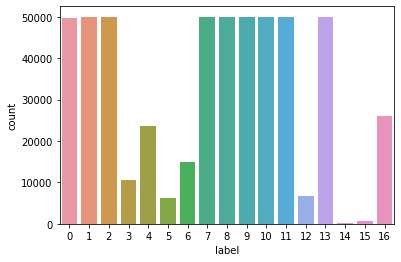

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

In [ ]:
df['label'].value_counts()

8     50000
13    50000
1     50000
2     50000
9     50000
7     50000
10    50000
11    50000
0     49670
16    25958
4     23648
6     14942
3     10624
12     6593
5      6155
15      644
14      111
Name: label, dtype: int64

In [ ]:
df['label'].value_counts()[16]

25958

In [ ]:
df['label'].value_counts().index[16]

14

In [ ]:
sample_amounts = {val:5000 if cnt>5000 else cnt for val, cnt in df['label'].value_counts().iteritems()}
print(sample_amounts)
df = (
    df.groupby('label').apply(lambda g: g.sample(
        # lookup number of samples to take
        n=sample_amounts[g.name],
        # enable replacement if len is less than number of samples expected
        replace=False  
    ))
)

{8: 5000, 13: 5000, 1: 5000, 2: 5000, 9: 5000, 7: 5000, 10: 5000, 11: 5000, 0: 5000, 16: 5000, 4: 5000, 6: 5000, 3: 5000, 12: 5000, 5: 5000, 15: 644, 14: 111}


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(df[['text', 'label']]).remove_columns(['__index_level_0__', '__index_level_1__']).train_test_split(test_size=0.1)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 68179
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7576
    })
})

In [ ]:
import tnkeeh as tn
cleander = tn.Tnkeeh(remove_diacritics = True)
cleaned_dataset = cleander.clean_hf_dataset(dataset, 'text')

Parameter 'function'=<function clean_hf_dataset.<locals>.<lambda> at 0x7fe29e22e200> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/68179 [00:00<?, ?ex/s]

  0%|          | 0/7576 [00:00<?, ?ex/s]

In [ ]:
def preprocess(x):
  out = ""
  for l in x:
    if l in vocab:
      out += l
  return out

def extract_features(x):
  x = [[char2idx[char] for char in preprocess(line)] for line in x]
  x = pad_sequences(x, padding='post', value=0, maxlen = 128)
  out = feature_extractor.predict(x)
  return out

In [ ]:
dataset_train_embeddings = dataset['train'].map(lambda examples:{'embedding': extract_features(examples['text'])}, batched=True)

In [ ]:
def get_closest_baits(sample_setences, k = 5):
  sample_embedding = extract_features(sample_sentence)
  dataset_test_similarity = dataset_train_embeddings.map(lambda examples:{'similarity': util.cos_sim(examples['embedding'], sample_embedding).numpy()}, batched=True)
  zipped = zip(dataset_test_similarity['text'], dataset_test_similarity['similarity'])
  return sorted(zipped, key=lambda x: x[1])[::-1][:10]

In [ ]:
labels = ['saree','kamel','mutakareb','mutadarak','munsareh','madeed','mujtath','ramal','baseet','khafeef','taweel','wafer','hazaj','rajaz','mudhare','muqtadheb','prose']

In [ ]:
cnt = 0 
for idx in range(len(dataset['test']['text'])): 
  sample_sentence = dataset['test']['text'][idx]
  if dataset['test']['label'][idx] == cnt:
    print(labels[dataset['test']['label'][idx]], dataset['test']['label'][idx])
    print(sample_sentence)
    print(get_closest_baits(sample_sentence))
    cnt += 1
    break

saree 0
كافلُ دينِ الله سيفٌ له # لا زالَ للأمةِ محبوبا


  0%|          | 0/69 [00:00<?, ?ba/s]

[('قلتُ له وَرْدٌ بخدَّيْك ذا # فقال لا بَلْ دمُ عُشّاقي', [0.9468253254890442]), ('باتَ يُعاطيني أَحاديثَه # وحبّذا ذلك مَكروعا', [0.9344676733016968]), ('يَمدَحُهُ القَومُ وَيَهجوهُم # ما شَكَرَ النِعمَةَ هاجيها', [0.9268677234649658]), ('لَيسَ كمثلي في الوَرى عاشقٌ # قالَ ولا مثليَ مَعشوقُ', [0.9261872172355652]), ('قبَّلها جلمودُ عرَّادةٍ # يُحسنُ للبخراءِ تقبيلا', [0.9245423078536987]), ('أُسرةُ مجدٍ شَرَعٌ كلُّها # أطرَبها المجد وأطراها', [0.9161920547485352]), ('أبلجُ فضَّاحٌ سنا نورِه # لسُنَّة البدر بإشراقِ', [0.9159823656082153]), ('ربَّ عِتاقٍ ضمَّرٍ قادَها # حقدٌ له في النَّفس إضمارُ', [0.9158334136009216]), ('قال سَفاهٌ ذكرُ ما قد مضى # وظَنَّ أنَّ اللومَ تأديبُ', [0.9154263734817505]), ('لَهُ مَحَلٌّ دونَ إِدراكِهِ # لِلشُّهبِ تَصعيدٌ وَتَصويبُ', [0.9133942127227783])]


In [ ]:
print(get_closest_baits(sample_sentence))